In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import os
from imageio.v3 import imread

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import time

try:
    from helper_functions import train_simple_network
except:
    import requests
    with open("helper_functions.py", "wb") as f:
        r = requests.get('https://raw.githubusercontent.com/Morshedy22/Inside-Deep-Learning-Book-Solutions/refs/heads/main/helper_functions.py')
        f.write(r.content)
    from helper_functions import train_simple_network

In [5]:
import torchvision 
from torchvision import transforms

In [6]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True)
x_example, y_example = mnist_data_train[0]
type(x_example)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.40MB/s]


PIL.Image.Image

In [7]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = mnist_data_train[0]
print(type(x_example))
print(x_example.shape)

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


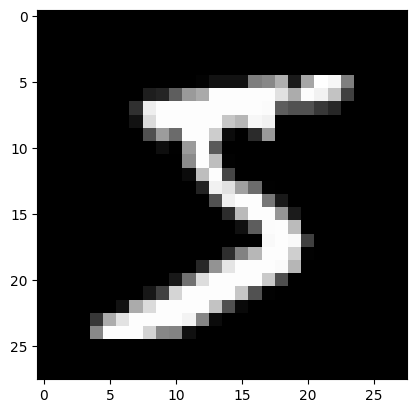

In [8]:
imshow(x_example[0,:], cmap='gray')

In [9]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]], dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


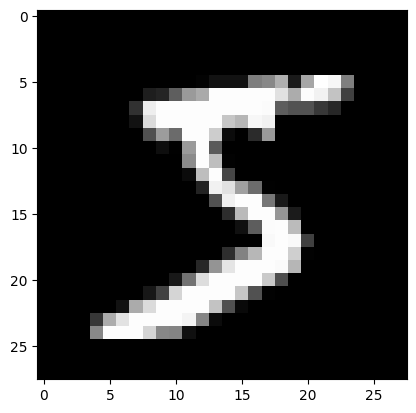

In [10]:
imshow(x_as_color.permute(1,2,0))

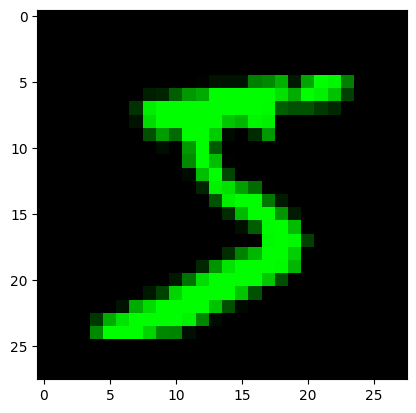

In [11]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]])
x_as_color[0,:] = 0 #No Red
#Leaving green alone
x_as_color[2,:] = 0 #No Blue
imshow(x_as_color.permute(1,2,0))

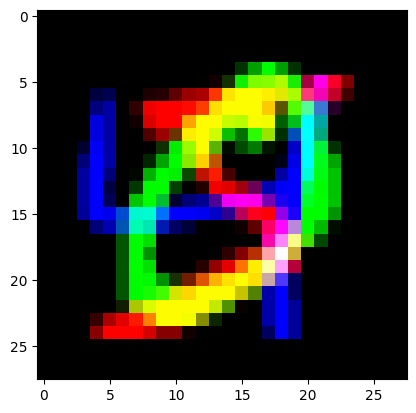

In [12]:
#grab 3 images
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]
#drop the labels
x1, x2, x3 = x1[0], x2[0], x3[0]
x_as_color = torch.stack([x1[0,:], x2[0,:], x3[0,:]], dim=0)
imshow(x_as_color.permute(1,2,0))

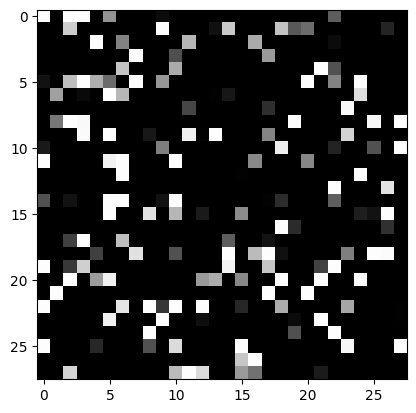

In [13]:
rand_order = torch.randperm(x_example.shape[1] * x_example.shape[2])
x_shuffled = x_example.view(-1)[rand_order].view(x_example.shape)
imshow(x_shuffled[0,:], cmap='gray')

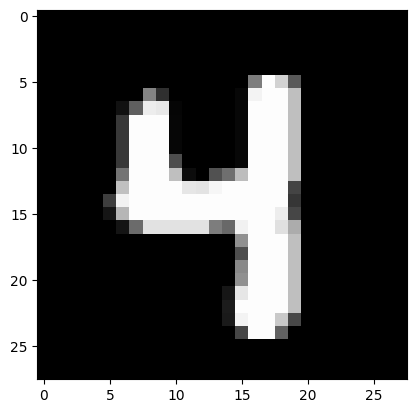

In [14]:
from scipy.signal import convolve
img_indx = 58
img = mnist_data_train[img_indx][0][0,:]
plt.imshow(img, vmin=0, vmax=1, cmap='gray')

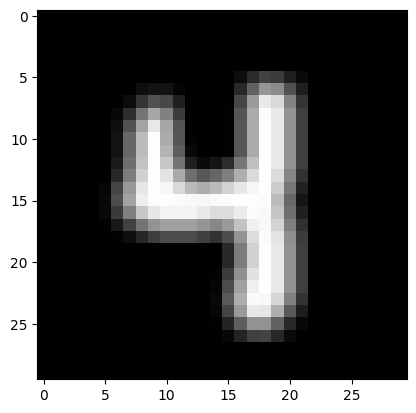

In [15]:
blur_filter = np.asarray([[1,1,1],
                          [1,1,1],
                          [1,1,1]
                         ])/9.0

blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap='gray')
plt.show()

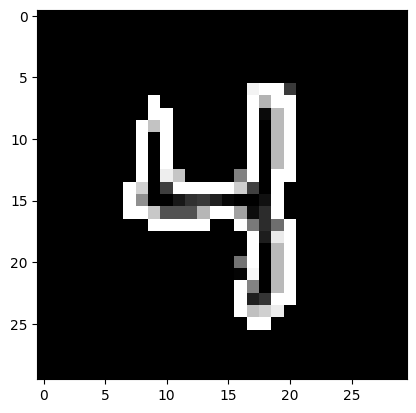

In [16]:
#We can find edges by focusing on the difference between a pixel, and its neighbors
edge_filter = np.asarray([[-1,-1,-1],
                          [-1, 8,-1],
                          [-1,-1,-1]
                         ])


edge_img = convolve(img, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

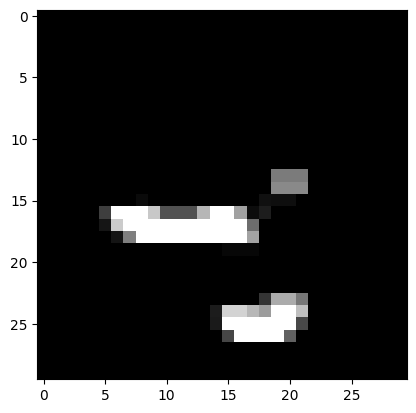

In [17]:
#We could look for only horizontal edges
h_edge_filter = np.asarray([[-1,-1,-1],
                          [0, 0,0],
                          [1, 1, 1]
                         ])


h_edge_img = convolve(img, h_edge_filter)
plt.imshow(h_edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

In [21]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#how large should our filters be?
K = 3
#for comparison, lets define a linear model of similar complexity
model_linear = nn.Sequential(
  nn.Flatten(), #(B, C, W, H) -> (B, C*W*H) = (B,D)
  nn.Linear(D, 256), 
  nn.Tanh(),
  nn.Linear(256, classes),
)

#A simple convolutional network:
model_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  nn.Conv2d(C, filters, K, padding=K//2), #$x \circledast G$
  nn.Tanh(),#Activation functions work on any size tensor
  nn.Flatten(), #Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  nn.Linear(filters*D, classes),
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=40)
fc_results = train_simple_network(model_linear, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=40)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: xlabel='epoch', ylabel='test Accuracy'>

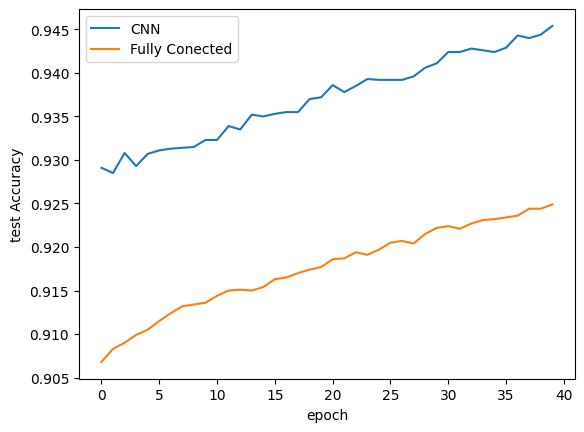

In [38]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='Fully Conected')

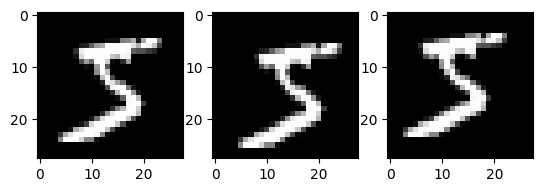

In [39]:
img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]
#move to the lower right, then upper left
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)
#plot the images
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()

In [40]:
#eval mode since we are not training
model = model_cnn.cpu().eval()

def pred(model, img):
    with torch.no_grad():#Always turn off gradients when evaluating
        w, h = img.shape#Whats the width/height of the image
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        x = img.reshape(1,-1,w,h)#reshape it as (B, C, W, H)
        logits = model(x) #Get the logits
        y_hat = F.softmax(logits, dim=1)#Turn into probabilities 
        return y_hat.numpy().flatten()#convert prediction to numpy array. 

In [41]:
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:          0.74040574
Lower Right Img Class 5 Prob:  0.44154897
Uper Left Img Class 5 Prob:    0.78861344


In [25]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(), 
  #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times. 
  nn.Linear(2*filters*D//(4**2), classes),
)

cnn_results_with_pool = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=40)

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
model = model_cnn_pool.cpu().eval()
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:          0.7556734
Lower Right Img Class 5 Prob:  0.80896246
Uper Left Img Class 5 Prob:    0.7988413


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: xlabel='epoch', ylabel='test Accuracy'>

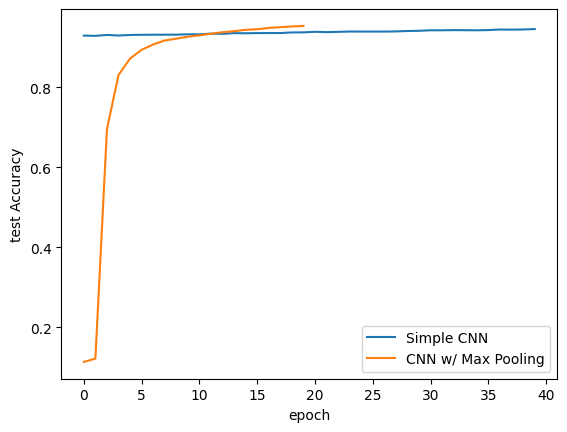

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='Simple CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')

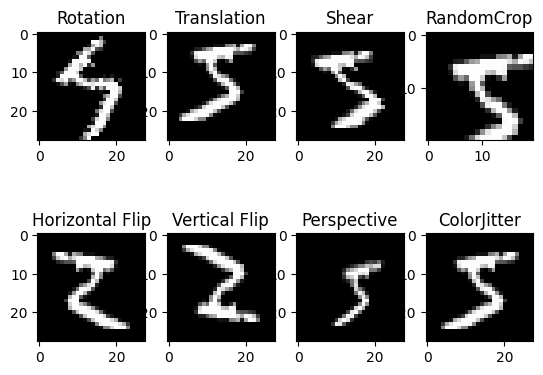

In [ ]:
#Several built-in transformations, given some agressive values to make their impact more obvious.  
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45),
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),   
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9)
}
#Convert the Tensor image back to a PIL image using a transform
pil_img = transforms.ToPILImage()(img)
#Plot a randomy application of each transform
f, axarr = plt.subplots(2,4)
for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img), cmap='gray')
    axarr[col,row].set_title(name)
plt.show()

In [26]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

mnist_train_t = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)
mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,  batch_size=B, num_workers=4)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B, num_workers=5)

cnn_results_with_pool_augmented = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader_t, test_loader=mnist_test_loader_t, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=40)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: xlabel='epoch', ylabel='test Accuracy'>

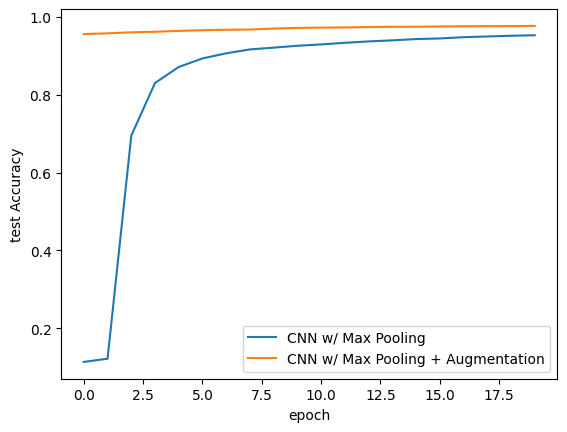

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool_augmented, label='CNN w/ Max Pooling + Augmentation')

In [27]:
print(cnn_results_with_pool['train Accuracy'][39])
print(cnn_results_with_pool['test Accuracy'][39])
print(cnn_results_with_pool_augmented['train Accuracy'][39])
print(cnn_results_with_pool_augmented['test Accuracy'][39])

0.9725166666666667
0.9737
0.9753333333333334
0.9859
